<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es entrenar un modelo de lenguaje basado en arquitectura de redes recurrentes a partir de un corpus de texto. En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la perplejidad. Parte del ejercicio consiste en estructurar adecuadamente el dataset para este problema.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import platform
import os
import platform
import pandas as pd
import requests

In [2]:
url = "https://raw.githubusercontent.com/cristianEmel/nlp/main/cyberbullying_tweets.csv"
response = requests.get(url)
response.raise_for_status()
df = pd.read_csv(io.StringIO(response.text), sep=',', on_bad_lines='skip', engine='python')
df = df.sample(frac=0.1, random_state=42) # Se decide reducir el dataset, dado que al tener uno grande o como el original falla el entrenamiento por desbordamiento de momoria
df.head()

,tweet_text
32384,I couldn't give two fuck on what niggers think...
13098,@Dreysander1 Absolutely.
655,Pq vc dorme tarde &gt;&gt;&gt;&gt; bullying
5388,@Phum_Ngcobo eyi buti I'm struggling with dis ...
20795,If you think that the actions of the followers...


In [3]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 3987


### Elegir el tamaño del contexto

In [4]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [5]:
# cada verso lo guardamos en una lista
text = list(df['tweet_text'])
text

["I couldn't give two fuck on what niggers think still getting my bandoe dumb fuckers",
 '@Dreysander1 Absolutely.',
 'Pq vc dorme tarde &gt;&gt;&gt;&gt; bullying',
 "@Phum_Ngcobo eyi buti I'm struggling with dis twitter ting * bbm cnt watch face*",
 "If you think that the actions of the followers of a religion represent the Thruthfulness of a religion, then you're an idiot. Also not all the Muslims blow themselves. ISIS represent 0.006 % of muslims according to Jonathan Brown.",
 'some dude keep sending me photos of himself blocking won’t do anything he will just create a new one sweetie how clear do I have to break it to you If I wasn’t interested the first 52837th times why will ur next try be any different?',
 "Yeah they're totally just rain vaginas @pjbish @Pocolow a man with an umbrella, just doesn't look right. I'm with you bro. #notsexist.",
 'No, it’s not only about the tweets, she bullied black girls in high school saying they didn’t belong. Imagine your whole teenage life be

In [6]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [7]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([ 19.,  70., 121., 145., 180., 198., 214., 239., 263., 272., 299.,
        264., 234., 149., 101.,  82.,  71.,  66.,  74.,  73.,  89., 102.,
        106., 123.,  68., 145.,  97.,  62.,  42.,   8.,   7.,   1.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1.  ,  2.96,  4.92,  6.88,  8.84, 10.8 , 12.76, 14.72, 16.68,
        18.64, 20.6 , 22.56, 24.52, 26.48, 28.44, 30.4 , 32.36, 34.32,
        36.28, 38.24, 40.2 , 42.16, 44.12, 46.08, 48.04, 50.  , 51.96,
        53.92, 55.88, 57.84, 59.8 , 61.76, 63.72, 65.68, 67.64, 69.6 ,
        71.56, 73.52, 75.48, 77.44, 79.4 , 81.36, 83.32, 85.28, 87.24,
        89.2 , 91.16, 93.12, 95.08, 97.04, 99.  ]),
 <BarContainer object of 50 artists>)

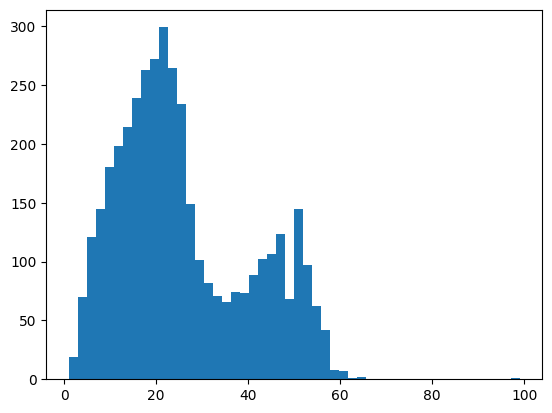

In [8]:
# Podemos ver su distribución
plt.hist(length_sentences,bins=50)

In [9]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 48


###  Tokenizar

In [10]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [11]:
tokenized_sentences

[[5, 733, 248, 285, 17, 20, 49, 107, 86, 123, 234, 18, 5116, 21, 3319],
 [3320, 1037],
 [2029, 2030, 5117, 3321, 389, 389, 389, 389, 149],
 [5118, 5119, 5120, 5121, 77, 2496, 28, 1687, 169, 5122, 3322, 2497, 368, 338],
 [43,
  6,
  86,
  10,
  1,
  679,
  8,
  1,
  772,
  8,
  2,
  209,
  2031,
  1,
  5123,
  8,
  2,
  209,
  100,
  188,
  76,
  92,
  150,
  16,
  30,
  1,
  61,
  1038,
  454,
  157,
  2031,
  1166,
  5124,
  8,
  61,
  680,
  3,
  5125,
  681],
 [101,
  413,
  255,
  1469,
  15,
  2498,
  8,
  865,
  3323,
  2032,
  57,
  132,
  46,
  72,
  42,
  1470,
  2,
  273,
  50,
  2499,
  71,
  734,
  57,
  5,
  37,
  3,
  1039,
  14,
  3,
  6,
  43,
  5,
  556,
  1471,
  1,
  111,
  5126,
  494,
  89,
  72,
  122,
  390,
  279,
  29,
  146,
  351],
 [360,
  434,
  866,
  42,
  5127,
  3324,
  5128,
  5129,
  2,
  137,
  28,
  76,
  5130,
  42,
  277,
  189,
  103,
  77,
  28,
  6,
  735,
  773],
 [58,
  140,
  16,
  112,
  40,
  1,
  578,
  62,
  35,
  68,
  59,
  7,
  25,
  

In [12]:
max_context_size+1

49

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [13]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.1, random_state=42)

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [14]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [15]:
len(tok_sent)

4909

In [16]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [17]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [18]:
train_seqs.shape

(151005, 49)

In [19]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [20]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'a',
 3: 'to',
 4: 'and',
 5: 'i',
 6: 'you',
 7: 'in',
 8: 'of',
 9: 'is',
 10: 'that',
 11: 'school',
 12: 'are',
 13: 'for',
 14: 'it',
 15: 'me',
 16: 'not',
 17: 'fuck',
 18: 'my',
 19: 'was',
 20: 'on',
 21: 'dumb',
 22: 'like',
 23: 'this',
 24: 'but',
 25: 'high',
 26: 'who',
 27: 'they',
 28: 'with',
 29: 'be',
 30: 'all',
 31: 'so',
 32: 'u',
 33: 'nigger',
 34: 'your',
 35: 'bullied',
 36: 'rape',
 37: 'have',
 38: 'people',
 39: 'as',
 40: 'about',
 41: 'gay',
 42: 'just',
 43: 'if',
 44: 'at',
 45: 'jokes',
 46: 'he',
 47: 'or',
 48: 'rt',
 49: 'what',
 50: 'one',
 51: 'when',
 52: 'by',
 53: 'bully',
 54: 'up',
 55: 'ass',
 56: 'we',
 57: 'do',
 58: 'no',
 59: 'girls',
 60: 'http',
 61: 'muslims',
 62: 'she',
 63: 'because',
 64: 'being',
 65: 'girl',
 66: 'amp',
 67: 'from',
 68: 'black',
 69: 'get',
 70: 'her',
 71: 'how',
 72: 'will',
 73: 'mkr',
 74: 'out',
 75: 'them',
 76: 'an',
 77: "i'm",
 78: 'can',
 79: "don't",
 80: 't',
 81: 'co',
 82: 'their',


In [21]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

13647

In [22]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'a': 2, 'to': 3, 'and': 4, 'i': 5, 'you': 6, 'in': 7, 'of': 8, 'is': 9, 'that': 10, 'school': 11, 'are': 12, 'for': 13, 'it': 14, 'me': 15, 'not': 16, 'fuck': 17, 'my': 18, 'was': 19, 'on': 20, 'dumb': 21, 'like': 22, 'this': 23, 'but': 24, 'high': 25, 'who': 26, 'they': 27, 'with': 28, 'be': 29, 'all': 30, 'so': 31, 'u': 32, 'nigger': 33, 'your': 34, 'bullied': 35, 'rape': 36, 'have': 37, 'people': 38, 'as': 39, 'about': 40, 'gay': 41, 'just': 42, 'if': 43, 'at': 44, 'jokes': 45, 'he': 46, 'or': 47, 'rt': 48, 'what': 49, 'one': 50, 'when': 51, 'by': 52, 'bully': 53, 'up': 54, 'ass': 55, 'we': 56, 'do': 57, 'no': 58, 'girls': 59, 'http': 60, 'muslims': 61, 'she': 62, 'because': 63, 'being': 64, 'girl': 65, 'amp': 66, 'from': 67, 'black': 68, 'get': 69, 'her': 70, 'how': 71, 'will': 72, 'mkr': 73, 'out': 74, 'them': 75, 'an': 76, "i'm": 77, 'can': 78, "don't": 79, 't': 80, 'co': 81, 'their': 82, 'know': 83, 'white': 84, 'now': 85, 'think': 86, 'bitch': 87, 'muslim': 88, 'why'

In [23]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {"couldn't": 13, 'still': 122, 'niggers': 137, 'my': 469, 'fuck': 562, 'two': 46, 'bandoe': 1, 'i': 1137, 'fuckers': 2, 'on': 519, 'getting': 60, 'give': 56, 'think': 178, 'what': 295, 'dumb': 552, 'dreysander1': 2, 'absolutely': 8, 'pq': 4, 'bullying': 100, 'gt': 21, 'tarde': 2, 'dorme': 1, 'vc': 4, 'cnt': 3, 'twitter': 89, 'bbm': 2, 'ting': 1, 'watch': 32, 'eyi': 1, "i'm": 196, 'with': 442, 'buti': 1, 'ngcobo': 1, 'phum': 1, 'dis': 5, 'face': 36, 'struggling': 3, 'religion': 59, 'themselves': 26, 'muslims': 226, 'represent': 3, 'jonathan': 1, 'a': 1526, 'blow': 9, 'the': 1771, 'that': 877, 'then': 148, "you're": 71, 'of': 1054, 'to': 1472, 'an': 212, 'actions': 15, 'you': 1140, 'brown': 16, '006': 1, 'all': 410, '0': 7, 'if': 327, 'followers': 13, 'idiot': 166, 'according': 16, 'thruthfulness': 1, 'also': 101, 'isis': 92, 'not': 541, 'sweetie': 3, 'first': 138, 'new': 46, 'himself': 11, 'wasn’t': 19, 'interested': 6, 'dude': 29, 'keep': 53, 'why': 179, 'som


### Definir el modelo

In [48]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 48, 5)               │          68,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 48, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 48, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 48, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 48, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 48, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 48, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 13648)               │         450,384 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 637,696 (2.43 MB)

 Trainable params: 637,696 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [25]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])
        self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

        self.info.append((count,count+len_seq))
        count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)} \n')

### Entrenamiento

In [49]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=64)

Epoch 1/20
2358/2360 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2476
 mean perplexity: 13234.965637163592 

2360/2360 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 7.2473
Epoch 2/20
2357/2360 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.8925
 mean perplexity: 47855.92431310971 

2360/2360 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 6.8925
Epoch 3/20
2357/2360 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.8711
 mean perplexity: 201329.93768438773 

2360/2360 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 6.8712
Epoch 4/20
2356/2360 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.8726
 mean perplexity: 214005.3541209721 

2360/2360 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - loss: 6.8726
Epoch 5/20
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.8670
 mean perplexity: 933587.1809117271 

2360/2360 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 6.8670
Epoch 6/20
2358/2360 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.8617
 mean perplexity: 1561552.6090451472 

2360/2360 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - lo


### Predicción de próxima palabra

In [28]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/

!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.7 MB/s eta 0:00:00


In [50]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b0bc63610ea4adfebc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b0bc63610ea4adfebc.gradio.live


### Generación de secuencias

In [51]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [52]:
# Tomamos twits incompletos para validar como completa
# Original: I couldn't give two fuck on what niggers think still getting my bandoe dumb fuckers
input_text="I couldn't give two fuck on what niggers think still"

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


"I couldn't give two fuck on what niggers think still the the the the the"

###  Beam search y muestreo aleatorio

In [53]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [54]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [55]:
# Original: I couldn't give two fuck on what niggers think still getting my bandoe dumb fuckers
salidas = beam_search(model,num_beams=10,num_words=6,input="I couldn't give two fuck on what niggers think")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

In [56]:
# Original: I couldn't give two fuck on what niggers think still getting my bandoe dumb fuckers
for idx, sequence  in enumerate(salidas):
  print(decode(salidas[idx]))

["i couldn't give two fuck on what niggers think a a the my because use"]
["i couldn't give two fuck on what niggers think a a the of and will"]
["i couldn't give two fuck on what niggers think a a the of and wapo"]
["i couldn't give two fuck on what niggers think a a the us why wrong"]
["i couldn't give two fuck on what niggers think a a the of and stan"]
["i couldn't give two fuck on what niggers think a a the of and i"]
["i couldn't give two fuck on what niggers think a a the of and equivalent"]
["i couldn't give two fuck on what niggers think a a the of and 5"]
["i couldn't give two fuck on what niggers think a a the of and were"]
["i couldn't give two fuck on what niggers think a a the of and as"]


### Conclusiones

*    Al probar con distintas conbinaciones, no se halle mejora significativa del modelo.

*    No es capaz de generar data acorde al dataset, por ejemplo generar el formato de etiqueta de usuario con @.

*    Parece no tener mucha variabilidad, ejemplo usado anteriormente, para todos los intentos los primeros cuatro palabras son i'm not bullied for